# Terrence Thesis - Case Study
***(Weekly Stress Period) Time Frame 2005-2014--- Changed grid size***

### Import Statements

In [1]:
import flopy
import flopy.modflow as mf
import flopy.utils as fu
import flopy.utils.binaryfile as bf
import matplotlib as mpl 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import platform
import shutil
import sys
import datetime
import math
from sklearn.metrics import mean_squared_error as mse
import flopy.mt3d as mt3
from flopy.export import vtk
import itertools as it
%matplotlib inline

### Setup folder where modflow-files are located

In [2]:
workspace = os.path.join('mf-data-weekly-grid')

In [3]:
if os.path.exists(workspace):
    shutil.rmtree(workspace)

if not os.path.exists(workspace):
    os.makedirs(workspace)

### Print versions

In [4]:
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('pandas version: {}'.format(pd.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.6.3 (v3.6.3:2c5fed8, Oct  3 2017, 18:11:49) [MSC v.1900 64 bit (AMD64)]
numpy version: 1.14.3
pandas version: 0.23.4
matplotlib version: 3.0.2
flopy version: 3.2.10


### Setup MF-Package

In [5]:
modelname = 'model'
exe_name = 'mf2005'

if platform.system() == 'Windows':
    exe_name += '.exe'

In [6]:
tm = mf.Modflow(modelname=modelname, exe_name=exe_name, version='mf2005', model_ws=workspace)

### Setup Discretization Package

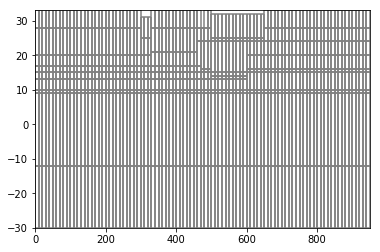

In [7]:
nrow = 1
ncol = 95
nlay = 10-1

Lx = 950
Ly = 1

botm = np.ones ( (nlay, nrow, ncol), dtype=np.int32 )
top = 33 * np.ones ( (nrow, ncol), dtype=np.int32 )

# Range does not include upper bound !!!
for i in range ( 30, 33):
    top[ :, i ] = 31
for i in range ( 47, 48 ):
    top[ :, i ] = 28
for i in range ( 50, 65):
    top[ :, i ] = 32

# N1 layer
botm[ 0, :, : ] = 28
for i in range ( 30, 33):
    botm[ 0,:, i ] = 25
for i in range ( 50, 65):
    botm[ 0,:, i ] = 25
## N2 layer
for i in range ( 0, 33 ):
    botm[ 1, :, i ] = 20
for i in range ( 33, 46 ):
    botm[ 1, :, i ] = 21.5
for i in range ( 46, 48 ):
    botm[ 1, :, i ] = 24
for i in range ( 48, ncol ):
    botm[ 1, :, i ] = 24.5
# N3 layer
for i in range ( 0, 47 ):
    botm[ 2, :, i ] = 17
for i in range ( 47, 50 ):
    botm[ 2, :, i ] = 16
for i in range ( 50, 60 ):
    botm[ 2, :, i ] = 15
for i in range ( 60, ncol ):
    botm[ 2, :, i ] = 20
# N4 layer
for i in range ( 0, 50 ):
    botm[ 3, :, i ] = 15
for i in range ( 50, 60 ):
    botm[ 3, :, i ] = 14
for i in range ( 60, ncol ):
    botm[ 3, :, i ] = 16
# N5 layer
for i in range ( 0, 60 ):
    botm[ 4, :, i ] = 13
for i in range ( 60, ncol ):
    botm[ 4, :, i ] = 15
# N6 layer
botm[ 5, :, : ] = 10
# N7 layer
botm[ 6, :, : ] = 9
# N8 layer
botm[ 7, :, : ] = -12.5
# N9 layer
botm[ 8, :, : ] = -30

delr = Lx / ncol
delc = Ly / nrow
nper = 505

perlen = np.ones ( nper) * 7
perlen[0] = 1

steady = np.full ( nper, False, dtype=bool )
steady[ 0 ] = True
dis = mf.ModflowDis(
    tm, 
    nlay=nlay,
    nrow=nrow, 
    ncol=ncol, 
    delr=delr, 
    delc=delc, 
    top=top, 
    botm=botm, 
    nper=nper,
    perlen = perlen,
    steady=steady,
    lenuni = 2,
    xul = 781658.203,
    yul = 5831682.381,
    proj4_str = "EPSG:32632",
    start_datetime = '11/05/2005',
    rotation = 3.3
)

modelxsect= flopy.plot.ModelCrossSection(model=tm, line={'Row':0})
linecollection= modelxsect.plot_grid()

### Setup Basic-Package

Specify boundary conditions and starting heads.

We can set one value for all cells.

In [8]:
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)

for i in range ( 1, nlay ):
    ibound[ i, :, 0 ] = -1
    ibound[ i, :, -1 ] = -1

for k in range ( 47, 49 ):
    ibound[ 0, :, k ] = 0

strt = np.ones ( (nlay, nrow, ncol), dtype=np.int32 ) * 28


for i in range ( 30, 33 ):
    strt[ 0, :, i ] = 29
for j in range ( 50, 65 ):
    strt[ 0, :, j ] = 29
    
bas = mf.ModflowBas(tm, ibound=ibound, strt=strt)

#bas.plot()

### Setup Constant Head Boundaries

In [9]:
csv = pd.read_csv('SPA101-weekly.csv', delimiter=' ')
chd_values = csv.iloc[ :, 1 ].values

#chd for each cell
#[lay, row, col, shead, ehead]
spchd = {}
spchd[0] = [
    [1, 0, 0, 28, 28], 
    [1, 0, ncol-1, 29.5, 29.5 ]
]

for layer in range (2, nlay):
    spchd[0].append ([layer, 0, 0, 28, 28 ])

for stress_period in range ( 1, nper ):
    spchd[stress_period] = [[1, 0, 0, chd_values[stress_period - 1], chd_values[stress_period]]]
    for layer in range (2, nlay):
        spchd[stress_period].append ([layer, 0, 0, chd_values[stress_period-1], chd_values[stress_period]])

chd = mf.ModflowChd(tm, stress_period_data=spchd)
#chd.plot()

### Setup General Head Boundaries

In [10]:
sp = {}
sp[0] = []

bas12_data = pd.read_csv ( 'Basin1&2-weekly.csv', delimiter=' ' ).iloc[ :, 1 ].values

    
bas3_data = pd.read_csv ( 'Basin3-weekly.csv', delimiter=' ' ).iloc[ :, 1 ].values

for col in range ( 30, 33 ):
    sp[ 0 ].append ( [ 0, 0, col,31, 30] )
    
for col in range ( 50, 65 ):
    sp[ 0 ].append ( [ 0, 0, col, 30, 10] )
    
for stress_period in range ( 1,  nper ):
    sp[ stress_period ] = [ ]
    for col in range ( 30, 33 ):
        if bas3_data[ stress_period - 1 ] == 0:
            sp[ stress_period ].append ( [ 0, 0, col, 28 , 3.5] )
        else:
            sp[ stress_period ].append ( [ 0, 0, col, 30 + 3  * bas3_data[ stress_period - 1 ] , 80 ] ) 
    for col in range ( 50, 65 ):
        if bas12_data[ stress_period - 1 ] == 0:
            sp[ stress_period ].append ( [ 0, 0, col, 29 , 1.2])
        else:
            sp[ stress_period ].append ( [ 0, 0, col, 30 + 4 * bas12_data[ stress_period - 1 ], 40] )
ghb = mf.ModflowGhb (tm,
                     stress_period_data=sp)
#ghb.plot()

### Setup Wells

In [11]:
# Pumping Well
wel_data = pd.read_csv('Pumping_well-weekly.csv', delimiter=' ').iloc[:, -2].values 

# -1 pumping rate of well 6
# -2 average pumping rate of well 5 and well 6

spwell = {}
spwell[0] = [7, 0, 41, 0]
for i in range(1, nper):
    spwell[i] = [7, 0, 41, -wel_data[i-1]/67]
    
wel = mf.ModflowWel(tm, stress_period_data=spwell, ipakcb=53)

#wel.plot()

### Setup Soil properties and Flow-Package

In [12]:
k1 = 1.7  # fine sand 1.728-7.776
k2 = 33  # middle sand 7.776-34.56
k3 = 80  # stone 34.56-103.68
k4 = 0.8  # clay
k5 = 40  # middle sand2
k6 = 6  # fine sand 1.728-7.776

# Set default hk-value value to k2
hk = np.ones((nlay, nrow, ncol)) * k2

# N1 layer
hk[0, :, :] = k1  # fine sand


# N2 layer
for i in range( 30, 60 ):
    hk[1, :, i] = k2  
for i in range( 55, 67 ):
    hk[1, :, i] = k1  # fine sand

#  N3 layer
hk[2, :, :] = k5  # middle sand2

# N4 layer
for i in range( 30, 44 ):
    hk[3, :, i] = k3  # sand & stone
for i in range( 44, 48 ):
    hk[3, :, i] = k4  # clay
for i in range( 48, 60 ):
    hk[3, :, i] = k3  # sand & stone
for i in range( 60, 65 ):
    hk[3, :, i] = k4  # clay

# N5 layer
hk[4, :, :] = k3
for i in range(36, 50 ):
    hk[4, :, i] = k6  # fine sand
for i in range( 50, 60 ):
    hk[4, :, i] = k3  # sand & stone
for i in range( 60, 65 ):
    hk[4, :, i] = k4  # clay

# 6 layer
hk[5, :, :] = k5  # middle sand2

# 7 layer
hk[6, :, :] = k5
for i in range(36 , 50 ):
    hk[6, :, i] = k6  # fine sand

# 8 layer
hk[7, :, :] = k5  # middle sand2

# 9 layer
hk[8, :, :] = k5  # middle sand2


# vertical HK
vk1 = k1*0.3
vk2 = k2*0.3
vk3 = k3*0.3
vk4 = k4*0.3
vk5 = k5*0.3
vk6 = k6*0.3

vka = np.ones((nlay, nrow, ncol), dtype=int) * vk2

# N1 layer
vka[0, :, :] = vk1  # fine sand


# N2 layer
for i in range( 30, 55 ):
    vka[1, :, i] = vk3  # sand & stone
for i in range( 55, 67 ):
    vka[1, :, i] = vk4  # clay

# N3 layer
vka[2, :, :] = vk5  # middle sand2

# N4 layer
for i in range( 30, 44 ):
    vka[3, :, i] = vk3  # sand & stone
for i in range( 44, 48 ):
    vka[3, :, i] = vk4  # clay
for i in range( 48, 60 ):
    vka[3, :, i] = vk3  # sand & stone
for i in range( 60, 65 ):
    vka[3, :, i] = vk4  # clay

# N5 layer
vka[4, :, :] = vk3
for i in range( 36, 50 ):
    vka[4, :, i] = vk6  # fine sand
for i in range( 50, 60 ):
    vka[4, :, i] = vk3  # sand & stone
for i in range( 60, 65 ):
    vka[4, :, i] = vk4  # clay

# N6 layer
vka[5, :, :] = vk5  # middle sand2

# N7 layer
vka[6, :, :] = vk5
for i in range( 36, 50):
    vka[6, :, i] = vk6  # fine sand

# N8 layer
vka[7, :, :] = vk5  # middle sand2

# N9 layer
vka[8, :, :] = vk5  # middle sand2

laytyp = [1, 1, 1, 1, 1, 1, 1, 1, 1]

# Specific yield 
sy1 = 0.2 # fine sand 
sy2 = 0.3 # middle sand
sy3 = 0.35 # stone 
sy4 = 0.05 # clay
sy5 = 0.3 # middle sand
sy6 = 0.2 # fine sand 

sy = np.ones((nlay, nrow, ncol)) * sy2

# N1 layer
sy[0, :, :] = sy1  # fine sand


# N2 layer
for i in range( 30, 55 ):
    sy[1, :, i] = sy3  # sand & stone
for i in range( 55, 67 ):
    sy[1, :, i] = sy4  # clay

# N3 layer
sy[2, :, :] = sy5  # middle sand2

# N4 layer
for i in range( 30, 44 ):
    sy[3, :, i] = sy3  # sand & stone
for i in range( 44, 48 ):
    sy[3, :, i] = sy4  # clay
for i in range( 48, 60 ):
    sy[3, :, i] = sy3  # sand & stone
for i in range( 60, 65 ):
    sy[3, :, i] = sy4  # clay

# N5 layer
sy[4, :, :] = sy3
for i in range( 36, 50 ):
    sy[4, :, i] = sy6  # fine sand
for i in range( 50, 60 ):
    sy[4, :, i] = sy3  # sand & stone
for i in range( 60, 65 ):
    sy[4, :, i] = sy4  # clay

# N6 layer
sy[5, :, :] = sy5  # middle sand2

# N7 layer
sy[6, :, :] = sy5
for i in range( 36, 50):
    sy[6, :, i] = sy6  # fine sand

# N8 layer
sy[7, :, :] = sy5  # middle sand2

# N9 layer
sy[8, :, :] = sy5  # middle sand2
ss = 7e-3

lpf = mf.ModflowLpf(tm, laytyp=laytyp, hk=hk, layvka=0, vka=vka, sy= sy ,  ss=ss, ipakcb=53)

#lpf.plot()

### Setup Solver Package and Output-control with defaults

In [13]:
budgetfile = '{}.cbc'.format(modelname)
budget_filerecord = [budgetfile]

oc = mf.ModflowOc(tm, 
                   save_every=True,
                   save_types=['SAVE HEAD', 'SAVE BUDGET'],
                   budget_filerecord=budget_filerecord,
                   compact=True
                  )


pcg = mf.ModflowPcg (tm, rclose=1e-1)

lmt = flopy.modflow.ModflowLmt ( tm, output_file_name = modelname + '.ftl', output_file_header='extended',
                                 output_file_format='formatted')

### Write Model input and run the model

In [14]:
tm.write_input()
success = tm.run_model(silent = True)
#flopy.export.shapefile_utils.model_attributes_to_shapefile('model.shp', tm, package_names = ['dis'])
shutil.copyfile (os.path.join(workspace, modelname + '.cbc'),os.path.join(workspace, modelname + '.bud') )

'mf-data-weekly-grid\\model.bud'

### Read and Plot Head Observations

SPA157.pdf


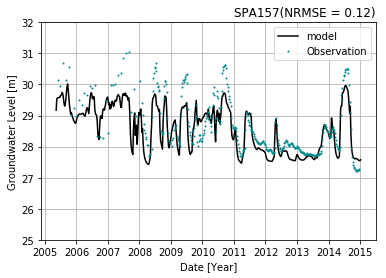

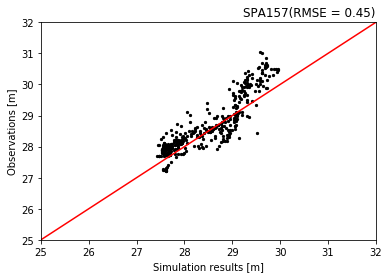

SPA168.pdf


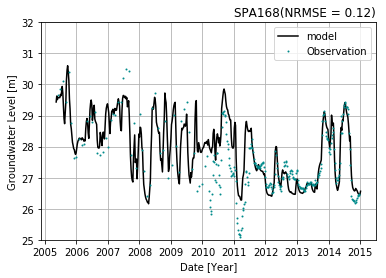

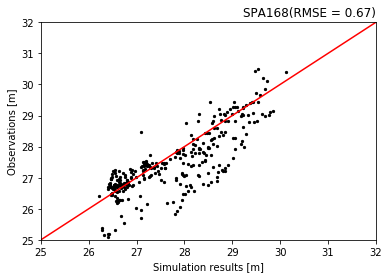

SPA165.pdf


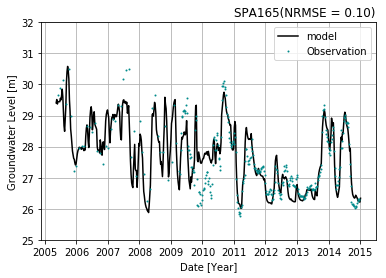

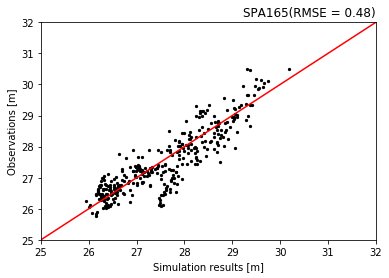

In [15]:
headobj = bf.HeadFile(os.path.join(workspace, modelname + '.hds'))

#observation wells

obs = [(1, 0, 65),
       (1, 0, 48),
       (1, 0, 46)]
name = ['SPA157','SPA168','SPA165']

for j in range (0,3):
    ts = headobj.get_ts ( idx= obs[j] )
    np.savetxt ( "HD.csv", ts, delimiter=',', header='Days,Head' )
    model = pd.read_csv ( 'HD.csv',delimiter=',')
    date = []
    for d in model['# Days']:
        date.append(datetime.datetime(2005,5,11)+datetime.timedelta(d-1)) 
    model['date'] = date
    model['nweek'] = np.int64((model['# Days']-1)/7+1)


   
    
    observation1 = pd.read_csv ( name[j]+'-weekly.csv' , delimiter=' ', header = -1)
    date = []
    for d in observation1.iloc[:,0]:
        date.append(datetime.datetime(2005,5,11)+datetime.timedelta((d-1)*7)) 
    observation1['date'] = date    
    observation1.columns = ['nweek','Head','date']

    plt.plot ( model['date'], model.iloc[:,1], label='model' , c = 'black')
    plt.plot( observation1['date'], observation1.iloc[:,1], '.', label='Observation1', markersize = 2, c='darkcyan' )
    plt.legend ( [ "model", "Observation" ] )
    plt.ylim(25,32)
    plt.xlabel ( 'Date [Year]' )
    plt.ylabel ( 'Groundwater Level [m]' )
    plt.grid(True)
    
    merge = pd.merge ( model, observation1,left_on='date',right_on='date',how='inner')
    merge = merge.iloc[:,[2,1,-1]]
    merge.columns = ['date','Head_model','Head_obs']
    
    h1 = merge['Head_model']
    h2 = merge['Head_obs']
    rmse = math.sqrt ( mse ( h1, h2 ) )
    nrmse = rmse/(np.max(h2)-np.min(h2))
    rmse = '{:01.2f}'.format(rmse)
    nrmse = '{:01.2f}'.format(nrmse)
    
    plt.title( name[j] + '(NRMSE = ' + str ( nrmse )+')', loc='right')
    title=name[j]+".pdf"
    print(title)
    #plt.savefig(title, dpi=300, bbox_inches='tight')
    plt.show ()
    
    
    u = []
    u = h1-h2
    a = h1 - h1

    
    x = [25,32]  
    y = [25,32]
    plt.scatter(h1,h2,s = 5,c='black')
    plt.plot(x,y,c='red')
    plt.ylim(25,32)
    plt.xlim(25,32)
    plt.xlabel('Simulation results [m]')
    plt.ylabel('Observations [m]')

    plt.title(name[j] + '(RMSE = ' + str ( rmse )+')', loc='right')
    title=name[j]+"2.pdf"
    #plt.savefig(title, dpi=300, bbox_inches='tight')
    plt.show()
    
    os.remove('HD.csv')



### MT3DMS 

In [16]:
if os.path.isfile('Basin-T-weekly.csv'):
    heat = pd.read_csv('Basin-T-weekly.csv',delimiter=' ',header = -1)
else:
    os.chdir("..")
    heat = pd.read_csv('Basin-T-weekly.csv',delimiter=' ',header = -1)

heat_basin = heat.iloc[:,-1].values

mt = flopy.mt3d.Mt3dms(modelname = 'heat',version='mt3dms',  exe_name='mt3dms5b', 
                       model_ws = workspace, 
                       modflowmodel = tm, ftlfilename = modelname + ".ftl", verbose = True)

adv = mt3.Mt3dAdv(mt, mixelm = -1, percel = 0.75)
icbund = np.ones((nlay, nrow, ncol), dtype=np.int32)
icbund[:,:,0] = -1
icbund[:,:,-1] = -1
sconc_1 = np.ones((nlay, nrow, ncol)) * 10

for i in range ( 30, 55):
    sconc_1[ :, :, i ] = 18
for i in range ( 38, 45):
    sconc_1[ :, :, i ] = 13.5
for i in range ( 30, 33):
    sconc_1[ 0, :, i] = 12
for i in range ( 50, 65):
    sconc_1[ 0, :, i] = 12
    
obs = [ ( 7, 0, 41)]

btn = mt3.Mt3dBtn(mt,icbund= icbund, ncomp=1,mcomp=0, sconc = sconc_1, prsity = sy, species_names=['heat'], obs=obs,
                nprobs=7)

dsp = mt3.Mt3dDsp(mt, al = 17, trpt= 0.1,trpv = 0.03, dmcoef= 0.17)

gcg = mt3.Mt3dGcg(mt, mxiter=1,iter1=50,isolve = 2,cclose = 1e-2,ncrs =1)             
rct = mt3.Mt3dRct(mt,isothm=1,ireact=0, prsity2= sy, igetsc=0, rhob = 1.87e3, sp1= 0.28e-3)


ssm_data = {}
ssm_data[0] = []

itype = flopy.mt3d.Mt3dSsm.itype_dict()

for i in range( 30, 33):
    ssm_data[0] = ssm_data[0]+ [[0, 0, i, 14 , itype[ 'GHB' ]]]
for i in range ( 50, 65):
    ssm_data[0].append( [ 0, 0, i, 14, itype[ 'GHB' ] ] )
    
for j in range (1,280):
    ssm_data[ j ] = [ ]
    for i in range ( 30, 33):
         ssm_data[ j ].append ( [ 0, 0, i, heat_basin[ j - 1 ], itype[ 'GHB' ] ] )
    for i in range ( 50, 65):
         ssm_data[ j ].append ( [ 0, 0, i, heat_basin[ j - 1 ], itype[ 'GHB' ] ] )
for j in range(280,nper):
    ssm_data[ j ] = [ ]
    for i in range ( 30, 33):
        ssm_data[ j ].append ( [ 0, 0, i, 14, itype[ 'GHB' ] ] )
    for i in range ( 50, 65):
        ssm_data[ j ].append ( [ 0, 0, i, 14, itype[ 'GHB' ] ] )

ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=ssm_data)

mt.write_input()
mt.run_model(silent = True)

Specified value of ftlfree conflicts with FTL file format
Switching ftlfree from False to True
adding Package:  ADV
adding Package:  BTN
adding Package:  DSP
adding Package:  GCG
adding Package:  RCT
adding Package:  SSM

Writing packages:
   Package:  ADV
   Package:  BTN
   Package:  DSP
   Package:  GCG
   Package:  RCT
   Package:  SSM
 


(False, [])

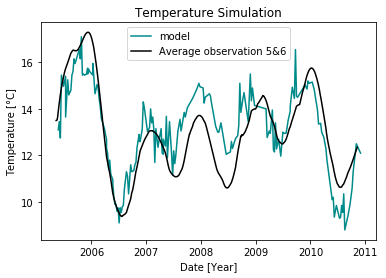

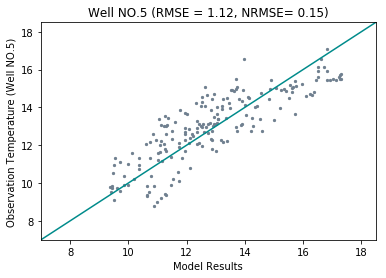

In [17]:
if os.path.isfile('N5_T-weekly2.csv'):
    n = pd.read_csv('N5_T-weekly2.csv',delimiter=',',header=0, index_col = 0)
    w = pd.read_csv('N6_T-weekly.csv',delimiter=',',header=0, index_col = 0)
else:
    os.chdir("..")
    n = pd.read_csv('N5_T-weekly2.csv',delimiter=',',header=0, index_col = 0)
    w = pd.read_csv('N6_T-weekly.csv',delimiter=',',header=0 ,index_col = 0)
if os.path.isfile('MT3D001.OBS'):
    t = pd.read_csv('MT3D001.OBS',delimiter=' ', nrows= 1150,skiprows=[0,1],skipinitialspace=True,skip_blank_lines=True,usecols=[1,2])

else:
    os.chdir(workspace)
    t = pd.read_csv('MT3D001.OBS',delimiter=' ', nrows= 1150,skiprows=[0,1],skipinitialspace=True,skip_blank_lines=True,usecols=[1,2])

t1 = t.iloc[:,0].values
y1 = []
for i in t1:
    y1.append([datetime.date(2005,5,11)+datetime.timedelta(i-1)])
t2 = t.iloc[:,1].values



n1 = n['days']
y2 = []
for i in n1:
    y2.append([datetime.date(2005,5,11)+datetime.timedelta(np.float64(i-1))])
n2 = n.iloc[:,0].values

w1 = w['days']
y3 = []
for i in w1:
    y3.append([datetime.date(2005,5,11)+datetime.timedelta(np.float64(i-1))])
w2 = w.iloc[:,0].values

plt.plot(y2,n2,c='darkcyan')
plt.plot(y1,t2,c='black')
plt.legend(['model','Average observation 5&6','ObservationN6'])
plt.xlabel ( 'Date [Year]' )
plt.ylabel ( 'Temperature [°C]' )
plt.title('Temperature Simulation')
plt.show()
plt.close()

x = pd.merge ( t, n,left_on= t.iloc[:,0].values,right_on='days',how='inner')

v1 = x.iloc[:,1].values
v2 = x.iloc[:,2].values
x1 = [7,18.5]
y1 = [7,18.5]
plt.scatter(v1,v2,s = 5,c='slategray')
plt.plot(x1,y1,c='darkcyan')
plt.ylim(7,18.5)
plt.xlim(7,18.5)
plt.xlabel ( 'Model Results' )
plt.ylabel ( 'Observation Temperature (Well NO.5)' )
rmse =  math.sqrt ( mse ( v1, v2 ) )
nrmse = rmse/(np.max(v2)-np.min(v1))
rmse = '{:01.2f}'.format(rmse)
nrmse= '{:01.2f}'.format(nrmse)
plt.title('Well NO.5 (RMSE = ' + str (rmse)+', NRMSE= '+ str(nrmse)+')')
plt.show()
plt.close()

### MODPATH 6

#### This is an Example for time series

In [18]:
mp = flopy.modpath.Modpath(modelname= modelname,
                               exe_name='C:/modflow/Packages/mp6',
                               modflowmodel= tm,
                               dis_file= tm.name  +'.dis',
                               head_file= tm.name +'.hds',
                               budget_file= tm.name + '.cbc',
                               )
options = [3,   #SimulationType           # 1 endpoint; 2 pathline; 3 timeseries
           1,   #TrackingDirection            # 1 forward; 2 backward
           1,   #WeakSinkOption            # 1 pass; 2 stop
           1,   #WeakSourceOption         # 1 pass; 2 stop
           1,   #ReferemceTimeOption       # 1 time value; 2 stress period, time step, relative offset
           1,   #StopOption                  # 1 stop with simulation 2; extend if steady state 3; specify time
           1,   #ParticleGenerationOption    # 1 automatic; 2 external file
           2,   #TimePointOption             # 1 none; 2 number at fixed intervals; 3 array
           1,   #BudgetOutputOption          # 1 none; 2 summary; 3 list of cells; 4 trace mode
           1,   #ZoneArrayOption          # 1 none; 2 read zone array(s) 
           1,   #RetardationOption           # 1 none; 2 read array(s) 
           1    #AdvectiveObservationsOption # 1 none; 2 saved for all time pts 3; saved for final time pt
          ] 
mpb = flopy.modpath.ModpathBas(mp, hdry=tm.lpf.hdry, laytyp=tm.lpf.laytyp, ibound=1, prsity = sy)

particles = 4 # particle numbers

ifaces = []
face_ct = []

group = []
group_placement = []
group_name = []

icnt = 0
for col in it.chain(range(30,33),range(50,65)):
    group_name.append('GHB{}'.format(icnt))
    group.append([0, 0, col, 0, 0, col])
    ifaces.append([[1, particles, particles], # side  
                   [2, particles, particles], # side 
                   [3, particles, particles], # side 
                   [4, particles, particles], # side 
                   [6, particles, particles]])# bottom
    face_ct.append(5)
    group_placement.append([1, 1, 1, 0, 1, 1])
    icnt += 1
    
sim = flopy.modpath.ModpathSim(mp, 
                 option_flags= options,
                 ref_time= 214, # the beginning time when you release the particles  
                 group_name=group_name, 
                 group_placement=group_placement,
                 group_region = group,  face_ct= face_ct,
                 ifaces=ifaces,
                 time_ct = 50  # the number of time steps needs to be read
                )
mp.write_input()
mp.run_model(silent=True)

(True, [])

In [19]:
def modpath (t):
    mp = flopy.modpath.Modpath(modelname= modelname,
                               exe_name='C:/modflow/Packages/mp6',
                               modflowmodel= tm,
                               dis_file= tm.name  +'.dis',
                               head_file= tm.name +'.hds',
                               budget_file= tm.name + '.cbc',
                                   )
    options = [2,   #SimulationType           # 1 endpoint; 2 pathline; 3 timeseries
               1,   #TrackingDirection            # 1 forward; 2 backward
               1,   #WeakSinkOption            # 1 pass; 2 stop
               1,   #WeakSourceOption         # 1 pass; 2 stop
               1,   #ReferemceTimeOption       # 1 time value; 2 stress period, time step, relative offset
               1,   #StopOption                  # 1 stop with simulation 2; extend if steady state 3; specify time
               1,   #ParticleGenerationOption    # 1 automatic; 2 external file
               2,   #TimePointOption             # 1 none; 2 number at fixed intervals; 3 array
               1,   #BudgetOutputOption          # 1 none; 2 summary; 3 list of cells; 4 trace mode
               1,   #ZoneArrayOption          # 1 none; 2 read zone array(s) 
               1,   #RetardationOption           # 1 none; 2 read array(s) 
               1    #AdvectiveObservationsOption # 1 none; 2 saved for all time pts 3; saved for final time pt
              ] 
    mpb = flopy.modpath.ModpathBas(mp, hdry=tm.lpf.hdry, laytyp=tm.lpf.laytyp, ibound=1, prsity = sy)
    
    particles = 4 # particle numbers
    
    ifaces = []
    face_ct = []
    
    group = []
    group_placement = []
    group_name = []
    
    icnt = 0
    for col in it.chain(range(30,33),range(50,65)):
        group_name.append('GHB{}'.format(icnt))
        group.append([0, 0, col, 0, 0, col])
        ifaces.append([[1, particles, particles], # side  
                       [2, particles, particles], # side 
                       [3, particles, particles], # side 
                       [4, particles, particles], # side 
                       [6, particles, particles]])# bottom
        face_ct.append(5)
        group_placement.append([1, 1, 1, 0, 1, 1])
        icnt += 1
        
    sim = flopy.modpath.ModpathSim(mp, 
                     option_flags= options,
                     ref_time= t, # the beginning time when you release the particles  
                     group_name=group_name, 
                     group_placement=group_placement,
                     group_region = group,  face_ct= face_ct,
                     ifaces=ifaces,
                    )
    mp.write_input()
    mp.run_model(silent=True)
    pthobj = flopy.utils.PathlineFile(os.path.join(modelname +'.mppth'))
    pdobj = flopy.utils.EndpointFile(os.path.join(modelname +'.mpend'))
    shutil.copyfile ( modelname + '.mppth', str(t) + modelname + '.path' )
    shutil.copyfile ( modelname + '.mpend', str(t) + modelname + '.end' )
    
    
    options[0] = 3
    
    sim = flopy.modpath.ModpathSim(mp, 
                     option_flags= options,
                     ref_time= t, # the beginning time when you release the particles  
                     group_name=group_name, 
                     group_placement=group_placement,
                     group_region = group,  face_ct= face_ct,
                     ifaces=ifaces,
                     time_ct = 100  # the number of time steps needs to be read
                    )
    mp.write_input()
    mp.run_model(silent=True)        
    shutil.copyfile ( modelname + '.mp.tim_ser', str(t) + modelname + '.timeseries' )

In [20]:
time = [
    79,
    257,
    438,
    622,
    790,
    969,
    1152,
    1345,
    1538,
    1739
]
for i in time:
    modpath(round(i))

****Warning -- two packages of the same type:  <class 'flopy.modpath.mpsim.ModpathSim'> <class 'flopy.modpath.mpsim.ModpathSim'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modpath.mpsim.ModpathSim'> <class 'flopy.modpath.mpsim.ModpathSim'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modpath.mpsim.ModpathSim'> <class 'flopy.modpath.mpsim.ModpathSim'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modpath.mpsim.ModpathSim'> <class 'flopy.modpath.mpsim.ModpathSim'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modpath.mpsim.ModpathSim'> <class 'flopy.modpath.mpsim.ModpathSim'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modpath.mpsim.ModpathSim'> <class 'flopy.modpath.mpsim.ModpathSim'>
replacing existing Package...
****Warning -- two packages of the same type: 